In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import sem, t
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score)
from utils import *

In [2]:
# import and edit first experiment
exp1_all = pd.read_csv('/home/tobamo/analize/model-tobamo/notebooks/MODEL2/results/training/n30/fold_final_predictions.csv')
exp1 = exp1_all.loc[exp1_all['mc_name'] == 'histogram']
exp1 = exp1.copy()
exp1['n'] = 10

# import the rest
exp2 = pd.read_csv('/home/tobamo/analize/model-tobamo/notebooks/MODEL3/results/training/hist_test/hist_test_fold_final_predictions.csv')
df_30 = pd.read_csv('results/training/hist_test/hist_test_fold_final_predictions_30.csv')
df_60 = pd.read_csv('results/training/hist_test/hist_test_fold_final_predictions_60_30.csv')

# add experiment number
exp1['exp'] = "1: snakemake all + Laplace's correction"
exp2['exp'] = "2: snakemake - Singapore SRR + Laplace's correction"
df_30['exp'] = "3: snakemake - Singapore SRR + fitted curve n=30"
df_60['exp'] = "4: snakemake - Singapore SRR + fitted curve n=60"

# df_30["accession"] = df_30["contig_name"].str.extract(r"^(.*\.\d)\_")
# df_60["accession"] = df_60["contig_name"].str.extract(r"^(.*\.\d)\_")

In [3]:
len(exp1), len(exp2), len(df_30), len(df_60)

(79200, 79200, 79200, 79200)

Beware: 'results/training/hist_test/hist_test_fold_final_predictions_60.csv' is buggy

In [4]:
def compute_metrics_by_seed_and_n(df):
    """
    Computes accuracy, F1, recall, precision, and AUC-ROC for each combination of random_seed and n.
    Returns a DataFrame with the results.
    """
    bins = df['n'].unique()
    random_seeds = df['random_seed'].unique()
    metrics_list = []

    for random_seed in random_seeds:
        for num in bins:
            df_mc = df[(df['n'] == num) & (df['random_seed'] == random_seed)]
            if df_mc.empty:
                continue
            y_true = df_mc['ground_truth']
            y_pred = df_mc['predicted_class']
            # Use prob_1 for AUC if available, else use predicted_class
            y_score = df_mc['prob_1'] if 'prob_1' in df_mc.columns else y_pred

            metrics = {
                'random_seed': random_seed,
                'n': num,
                'accuracy': accuracy_score(y_true, y_pred),
                'f1_score': f1_score(y_true, y_pred),
                'recall': recall_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred),
                'auc_roc': roc_auc_score(y_true, y_score)
            }
            metrics_list.append(metrics)

    return pd.DataFrame(metrics_list)




def summarize_metrics_with_ci(metrics_df, confidence_level=0.95):
    """
    For each value of 'n' and each metric, computes mean, std, and confidence interval.
    Returns a summary DataFrame.
    """
    summary_list = []
    for num in metrics_df['n'].unique():
        df_mc = metrics_df[metrics_df['n'] == num]
        for metric in ['accuracy', 'f1_score', 'recall', 'precision', 'auc_roc']:
            mean = df_mc[metric].mean()
            std = df_mc[metric].std()
            n = len(df_mc[metric])
            se = sem(df_mc[metric])
            h = se * t.ppf((1 + confidence_level) / 2, n - 1) if n > 1 else 0
            ci_lower = mean - h
            ci_upper = mean + h
            summary = {
                'n': num,
                'metric': metric,
                'mean': mean,
                'std': std,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper
            }
            summary_list.append(summary)
    return pd.DataFrame(summary_list)

In [5]:
metrics_1 = compute_metrics_by_seed_and_n(exp1)
metrics_2 = compute_metrics_by_seed_and_n(exp2)
metrics30 = compute_metrics_by_seed_and_n(df_30)
metrics60 = compute_metrics_by_seed_and_n(df_60)

summary1 = summarize_metrics_with_ci(metrics_1)
summary2 = summarize_metrics_with_ci(metrics_2)
summary30 = summarize_metrics_with_ci(metrics30)
summary60 = summarize_metrics_with_ci(metrics60)

summary1['exp'] = "1: snakemake all + Laplace's correction"
summary2['exp'] = "2: snakemake - Singapore SRR + Laplace's correction"
summary30['exp'] = "3: snakemake - Singapore SRR + fitted curve n=30"
summary60['exp'] = "4: snakemake - Singapore SRR + fitted curve n=60"

summary_combined = pd.concat([summary1, summary2, summary30, summary60], ignore_index=True)
summary_combined

,n,metric,mean,std,ci_lower,ci_upper,exp
0,10,accuracy,0.975997,0.002040,0.975236,0.976759,1: snakemake all + Laplace's correction
1,10,f1_score,0.982470,0.001498,0.981911,0.983030,1: snakemake all + Laplace's correction
2,10,recall,0.970383,0.002682,0.969381,0.971384,1: snakemake all + Laplace's correction
3,10,precision,0.994870,0.002131,0.994075,0.995666,1: snakemake all + Laplace's correction
4,10,auc_roc,0.997551,0.000402,0.997401,0.997701,1: snakemake all + Laplace's correction
5,10,accuracy,0.989192,0.001711,0.988553,0.989831,2: snakemake - Singapore SRR + Laplace's corre...
6,10,f1_score,0.992164,0.001243,0.991700,0.992628,2: snakemake - Singapore SRR + Laplace's corre...
7,10,recall,0.987195,0.001858,0.986501,0.987889,2: snakemake - Singapore SRR + Laplace's corre...
8,10,precision,0.997187,0.001427,0.996654,0.997719,2: snakemake - Singapore SRR + Laplace's corre...
9,10,auc_roc,0.999350,0.000263,0.999251,0.999448,2: snakemake - Singapore SRR + Laplace's corre...


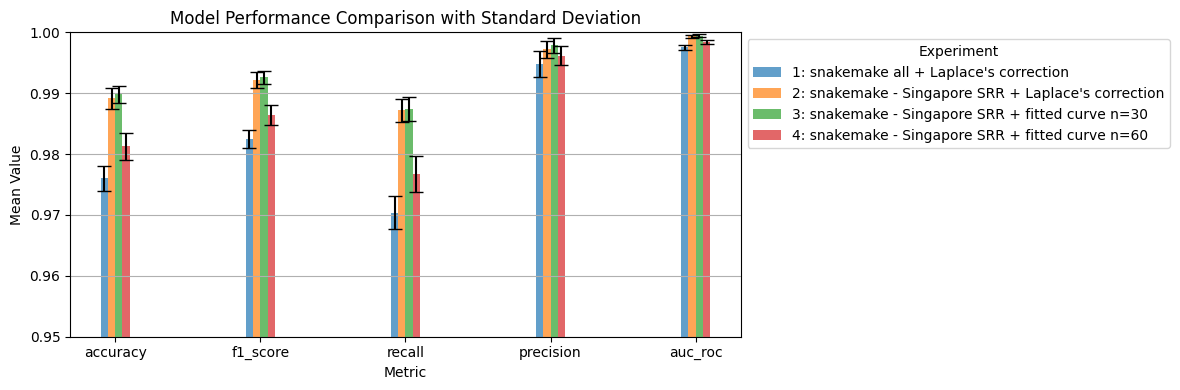

In [ ]:
# Extract unique metrics and models
metrics = summary_combined['metric'].unique()
bins = summary_combined['exp'].unique()

# Prepare data for plotting
means = np.array([summary_combined[summary_combined['exp'] == bin]['mean'].values for bin in bins])
std_devs = np.array([summary_combined[summary_combined['exp'] == bin]['std'].values for bin in bins])

# Bar width
x = np.arange(len(metrics))  # X-axis locations for the groups
width = 0.05  # Width of the bars

# Create figure
fig, ax = plt.subplots(figsize=(14, 4))

# Plot bars with error bars
for i in range(len(bins)):
    ax.bar(x + i * width, means[i], width, yerr=std_devs[i], capsize=5, label=bins[i], alpha=0.7)

# Formatting
ax.set_xticks(x + width * (len(bins) - 1) / 2)
ax.set_xticklabels(metrics)
ax.set_xlabel('Metric')
ax.set_ylabel('Mean Value')
ax.set_ylim(0.95, 1)  # Adjust y-axis limits for better resolution
ax.set_title('Model Performance Comparison with Standard Deviation')

# Place legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Experiment')

# Add white space between metrics
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(axis='y')
plt.show()

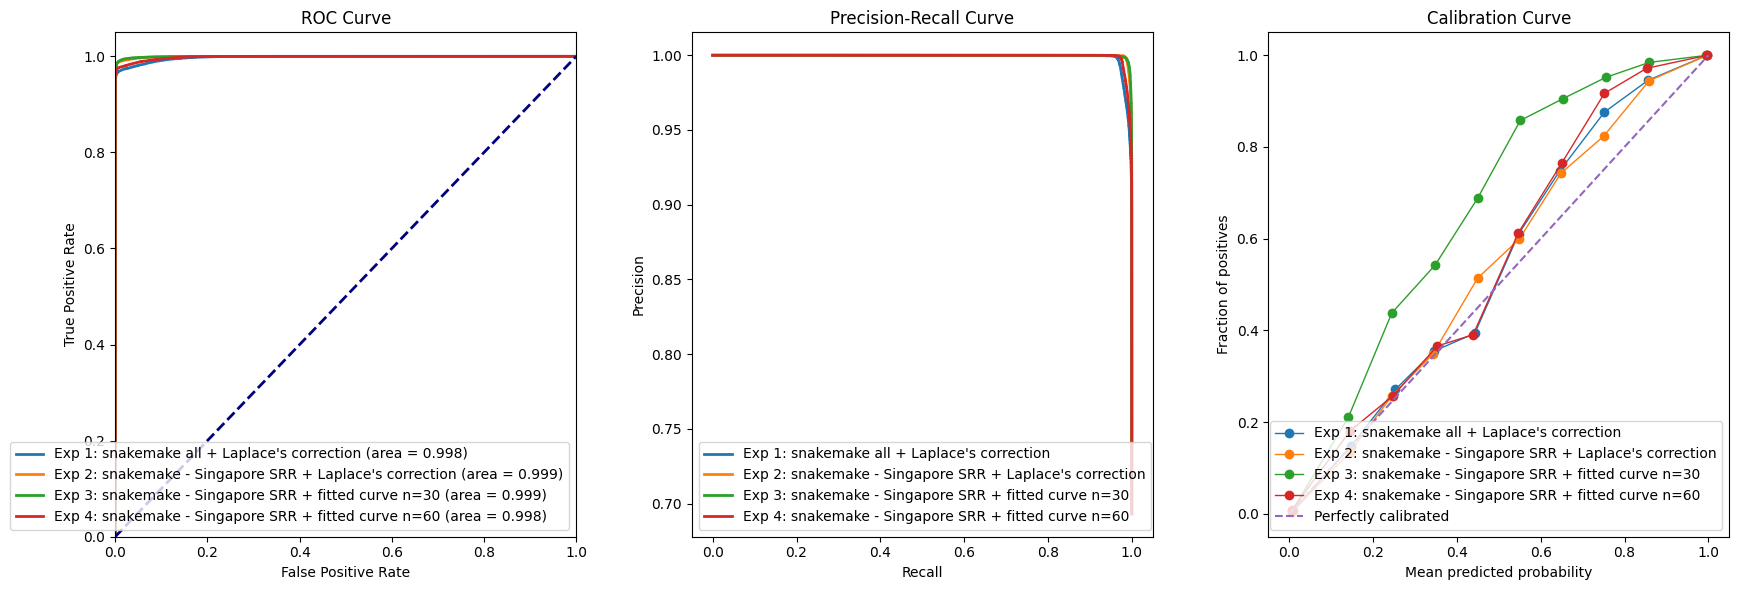

In [7]:
df = pd.concat([exp1, exp2, df_30, df_60], ignore_index=True)
methods = df['exp'].unique()

# Aggregate results across all folds for each method
aggregated_results = []

for method in methods:
    method_data = df[df['exp'] == method]
    aggregated_results.append(method_data)

# Combine all aggregated results into a single DataFrame
combined_results = pd.concat(aggregated_results)

# Plot ROC curve, Precision-Recall curve, and Calibration curve for each method
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot ROC Curve for each method
for method in methods:
    method_data = combined_results[combined_results['exp'] == method]
    y_true = method_data['ground_truth']
    y_scores = method_data['prob_1']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'Exp {method} (area = {roc_auc:.3f})')

axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Plot Precision-Recall Curve for each method
for method in methods:
    method_data = combined_results[combined_results['exp'] == method]
    y_true = method_data['ground_truth']
    y_scores = method_data['prob_1']
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    axes[1].plot(recall, precision, lw=2, label=f'Exp {method}')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")

# Plot Calibration Curve for each method
for method in methods:
    method_data = combined_results[combined_results['exp'] == method]
    y_true = method_data['ground_truth']
    y_scores = method_data['prob_1']
    prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=10)
    axes[2].plot(prob_pred, prob_true, marker='o', lw=1, label=f'Exp {method}')

axes[2].plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
axes[2].set_xlabel('Mean predicted probability')
axes[2].set_ylabel('Fraction of positives')
axes[2].set_title('Calibration Curve')
axes[2].legend(loc="lower right")

plt.tight_layout()
plt.show()

Plot contig length distribution of cross validation test contigs

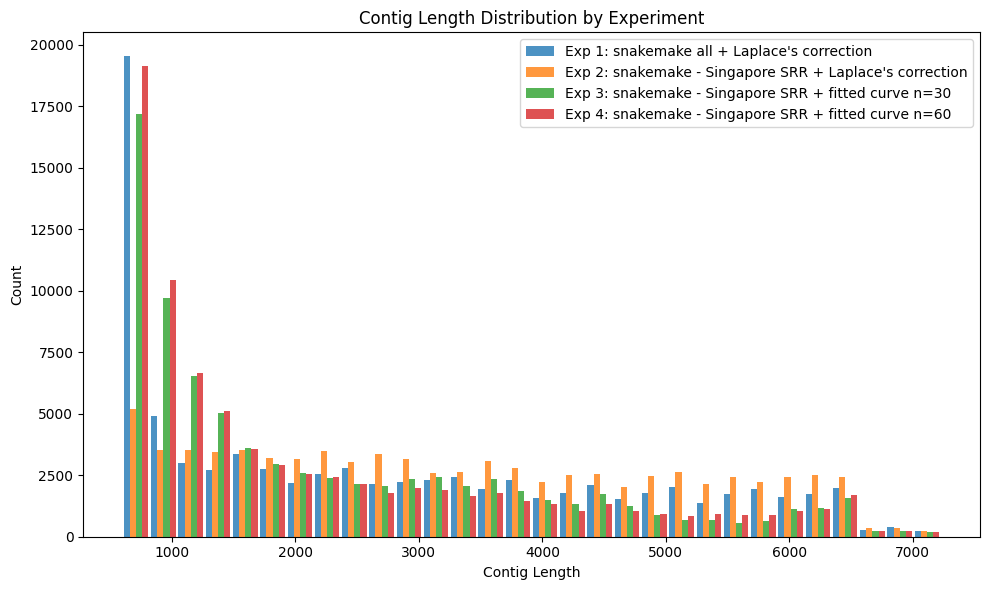

In [8]:
exp_values = sorted(df['exp'].unique())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
n_exp = len(exp_values)

# Define bins for all data
bins = np.histogram_bin_edges(df['contig_length'], bins=30)

plt.figure(figsize=(10, 6))

bar_width = (bins[1] - bins[0]) / n_exp * 0.9  # 90% of bin width, divided among exps

for i, (exp, color) in enumerate(zip(exp_values, colors)):
    data = df[df['exp'] == exp]['contig_length']
    counts, _ = np.histogram(data, bins=bins)
    # Shift bars for each experiment
    bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2
    plt.bar(
        bin_centers + (i - n_exp/2) * bar_width + bar_width/2,
        counts,
        width=bar_width,
        color=color,
        alpha=0.8,
        label=f'Exp {exp}',
        align='center'
    )

plt.xlabel('Contig Length')
plt.ylabel('Count')
plt.title('Contig Length Distribution by Experiment')
plt.legend()
plt.tight_layout()
plt.show()

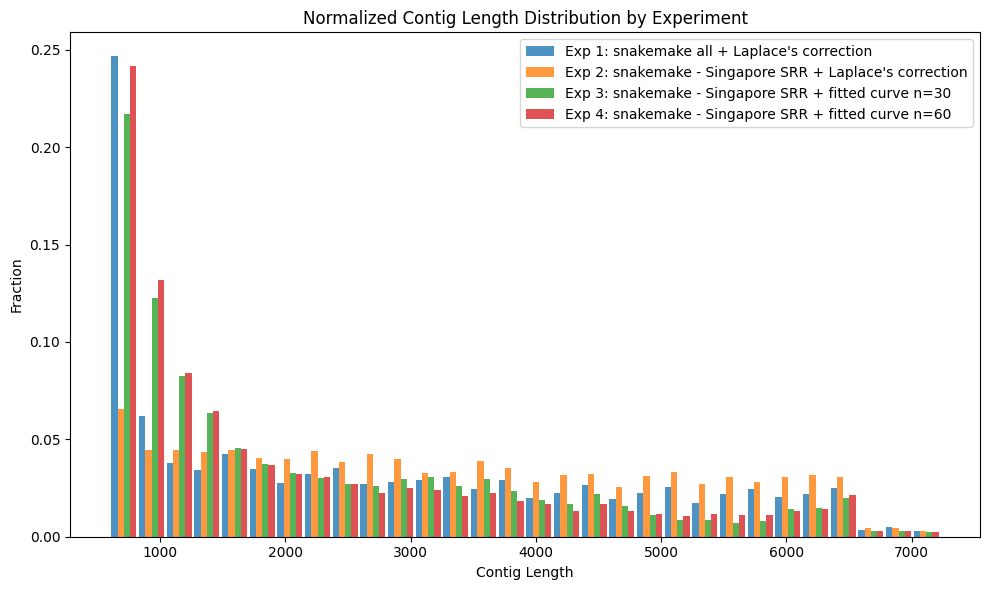

In [9]:
import matplotlib.pyplot as plt
import numpy as np

exp_values = sorted(df['exp'].unique())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
n_exp = len(exp_values)

# Define bins for all data
bins = np.histogram_bin_edges(df['contig_length'], bins=30)

plt.figure(figsize=(10, 6))

bar_width = (bins[1] - bins[0]) / n_exp * 0.9  # 90% of bin width, divided among exps

for i, (exp, color) in enumerate(zip(exp_values, colors)):
    data = df[df['exp'] == exp]['contig_length']
    counts, _ = np.histogram(data, bins=bins)
    counts = counts / counts.sum()  # Normalize to sum to 1
    bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2
    plt.bar(
        bin_centers + (i - n_exp/2) * bar_width + bar_width/2,
        counts,
        width=bar_width,
        color=color,
        alpha=0.8,
        label=f'Exp {exp}',
        align='center'
    )

plt.xlabel('Contig Length')
plt.ylabel('Fraction')
plt.title('Normalized Contig Length Distribution by Experiment')
plt.legend()
plt.tight_layout()
plt.show()

distribution of false predictions

In [10]:
df['correct'] = df['ground_truth'] == df['predicted_class']

col_labels = {1: 'tobamo', 0: 'outgroup'}
df['ground_truth_label'] = df['ground_truth'].map(col_labels)

df

,fold_idx,mc_name,contig_name,prob_1,ground_truth,treshold,random_seed,contig_length,predicted_class,n,exp,correct,ground_truth_label
0,0,histogram,J04342.1_Barley_stripe_mosaic_virus_alpha_RNA_...,0.000855,0,0.5,42,3768,0,10,1: snakemake all + Laplace's correction,True,outgroup
1,0,histogram,J04342.1_Barley_stripe_mosaic_virus_alpha_RNA_...,0.001301,0,0.5,42,765,0,10,1: snakemake all + Laplace's correction,True,outgroup
2,0,histogram,J04342.1_Barley_stripe_mosaic_virus_alpha_RNA_...,0.002193,0,0.5,42,3078,0,10,1: snakemake all + Laplace's correction,True,outgroup
3,0,histogram,J04342.1_Barley_stripe_mosaic_virus_alpha_RNA_...,0.001519,0,0.5,42,1782,0,10,1: snakemake all + Laplace's correction,True,outgroup
4,0,histogram,J04342.1_Barley_stripe_mosaic_virus_alpha_RNA_...,0.002161,0,0.5,42,1525,0,10,1: snakemake all + Laplace's correction,True,outgroup
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,4,histogram,Z97873.1_Beet_soil-borne_virus_RNA1_for_145_kD...,0.000084,0,0.5,71,2667,0,10,4: snakemake - Singapore SRR + fitted curve n=60,True,outgroup
316796,4,histogram,Z97873.1_Beet_soil-borne_virus_RNA1_for_145_kD...,0.000121,0,0.5,71,1492,0,10,4: snakemake - Singapore SRR + fitted curve n=60,True,outgroup
316797,4,histogram,Z97873.1_Beet_soil-borne_virus_RNA1_for_145_kD...,0.000101,0,0.5,71,1028,0,10,4: snakemake - Singapore SRR + fitted curve n=60,True,outgroup
316798,4,histogram,Z97873.1_Beet_soil-borne_virus_RNA1_for_145_kD...,0.000386,0,0.5,71,2418,0,10,4: snakemake - Singapore SRR + fitted curve n=60,True,outgroup


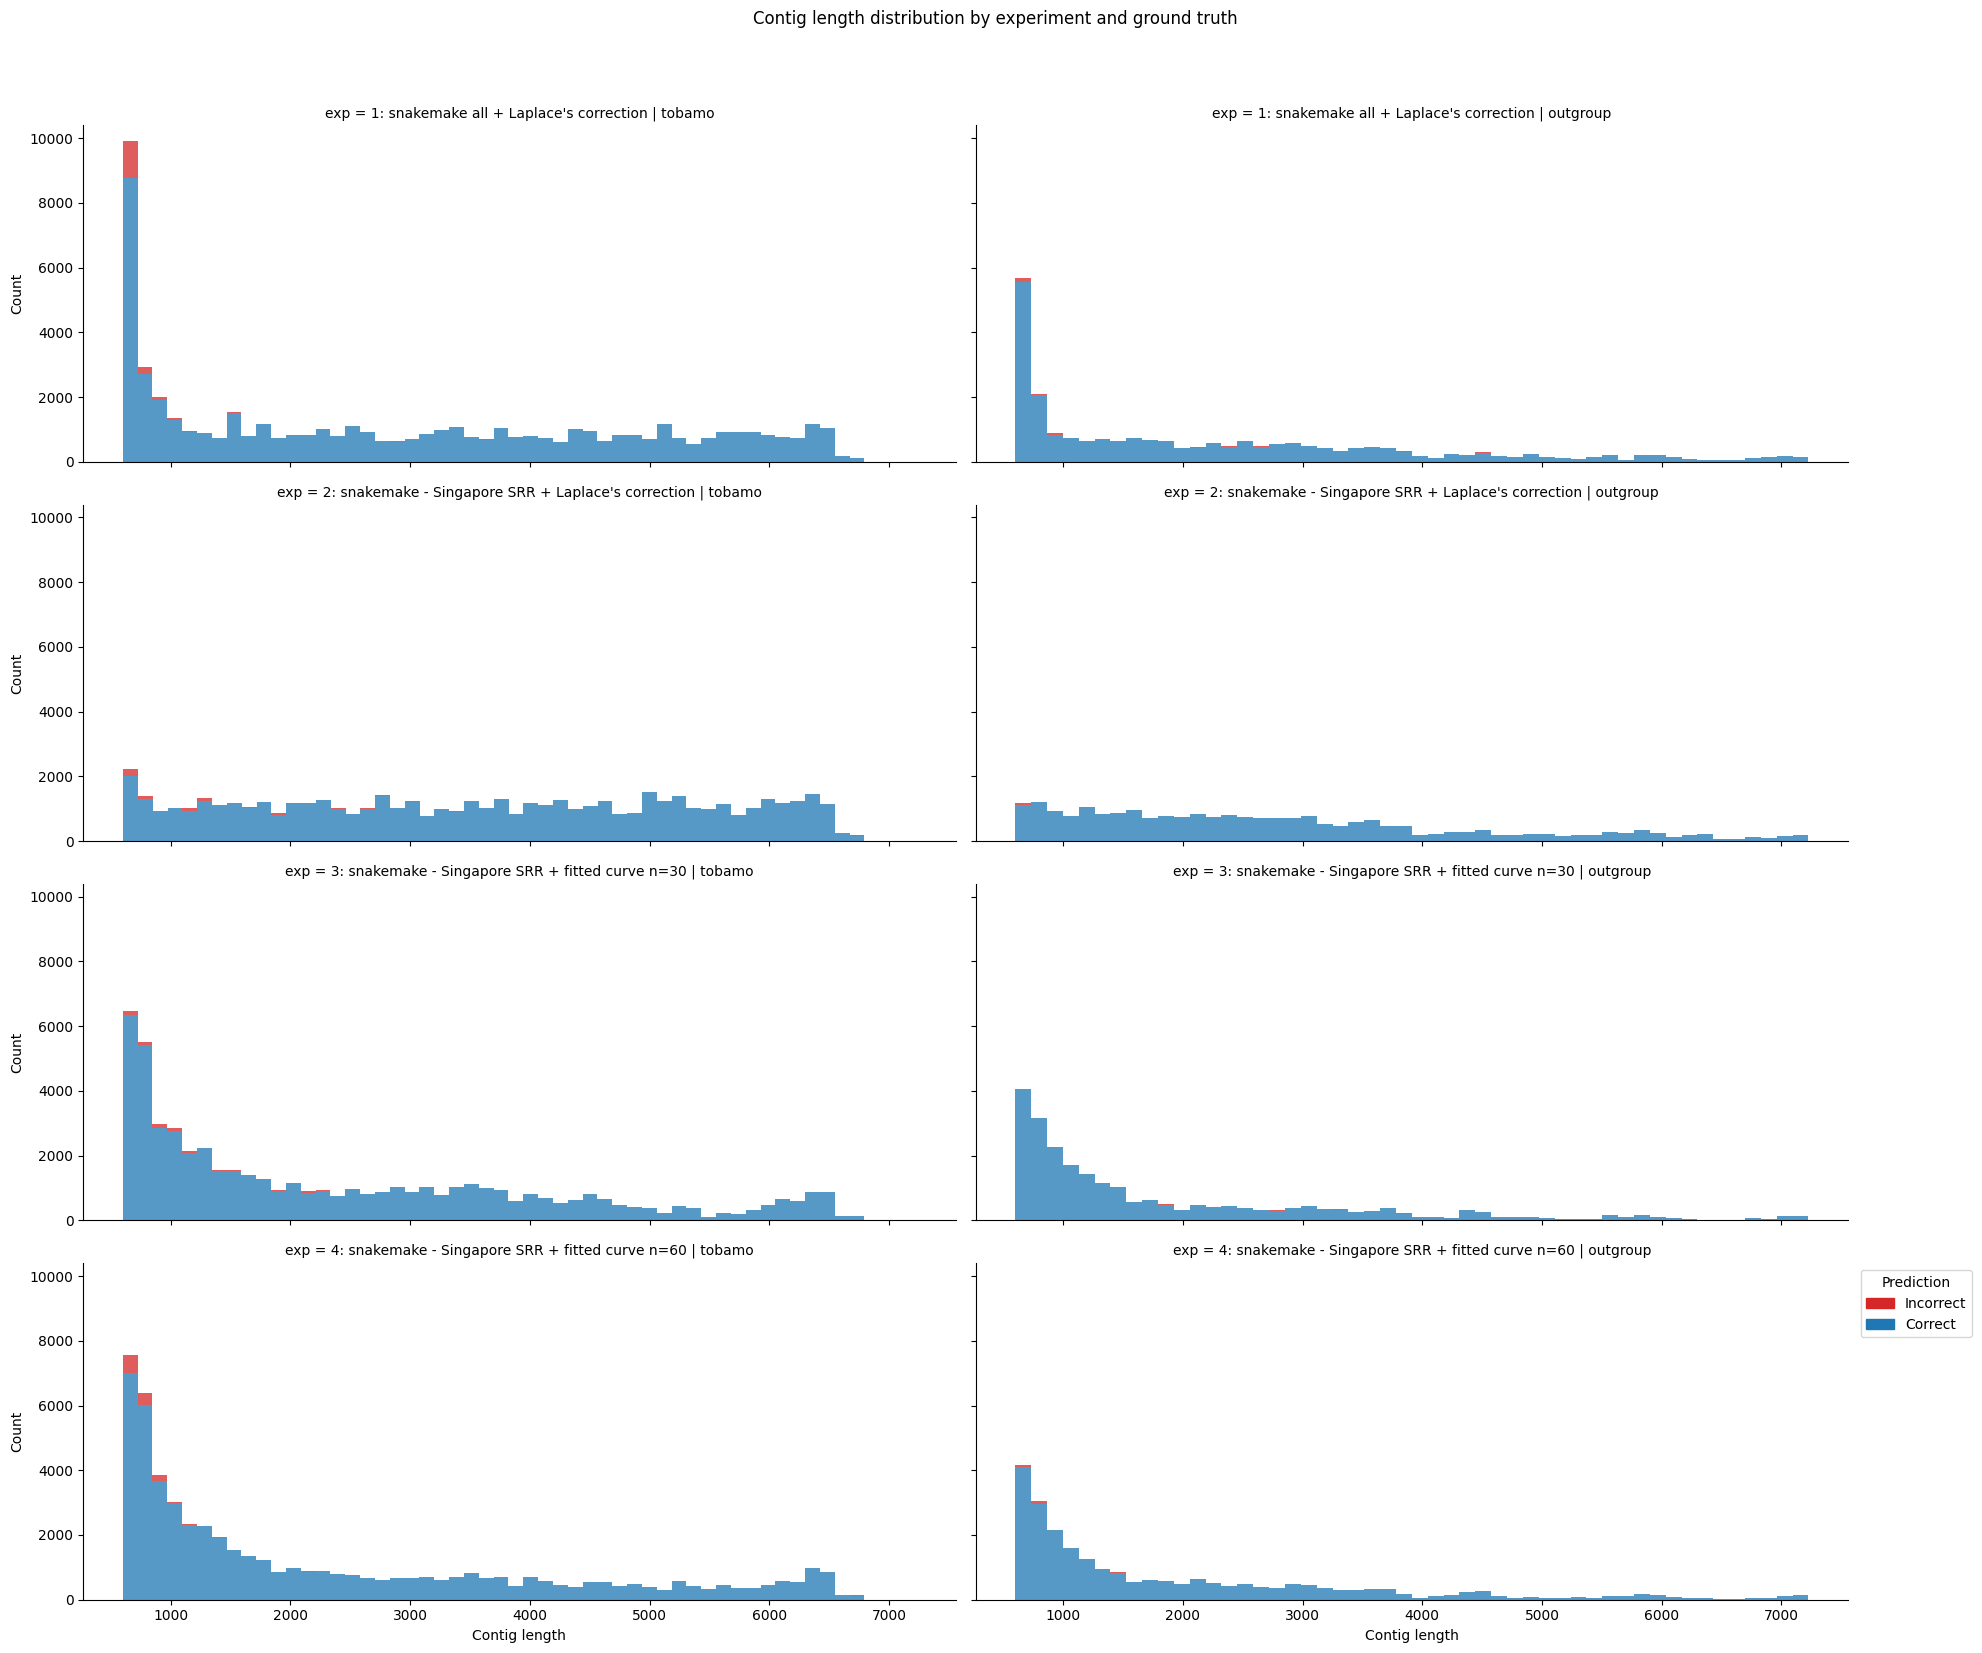

In [12]:
g = sns.FacetGrid(
    df,
    row="exp",
    col="ground_truth_label",
    col_order=['tobamo', 'outgroup'],
    height=4,          # Increase height for better readability
    aspect=2.5,        # Make each subplot wider
    sharey=True,
    margin_titles=False
)
g.map_dataframe(
    sns.histplot,
    x="contig_length",
    hue="correct",
    bins=50,
    multiple="stack",
    palette={0: "tab:red", 1: "tab:blue"},
    edgecolor=None
)
g.set_axis_labels("Contig length", "Count")
g.set_titles(row_template="exp = {row_name}", col_template="{col_name}")

# Reduce space between subplots
g.fig.subplots_adjust(wspace=0.05, hspace=0.15)

# Custom legend with correct colors and labels
handles = [
    mpatches.Patch(color='tab:red', label='Incorrect'),
    mpatches.Patch(color='tab:blue', label='Correct')
]
plt.legend(handles=handles, title="Prediction", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.suptitle("Contig length distribution by experiment and ground truth", y=1.03)
plt.tight_layout()
plt.show()

In [21]:
df = df[df['correct'] == False]

/tmp/ipykernel_3625839/3554868397.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ground_truth_label'] = df['ground_truth'].map(col_labels)


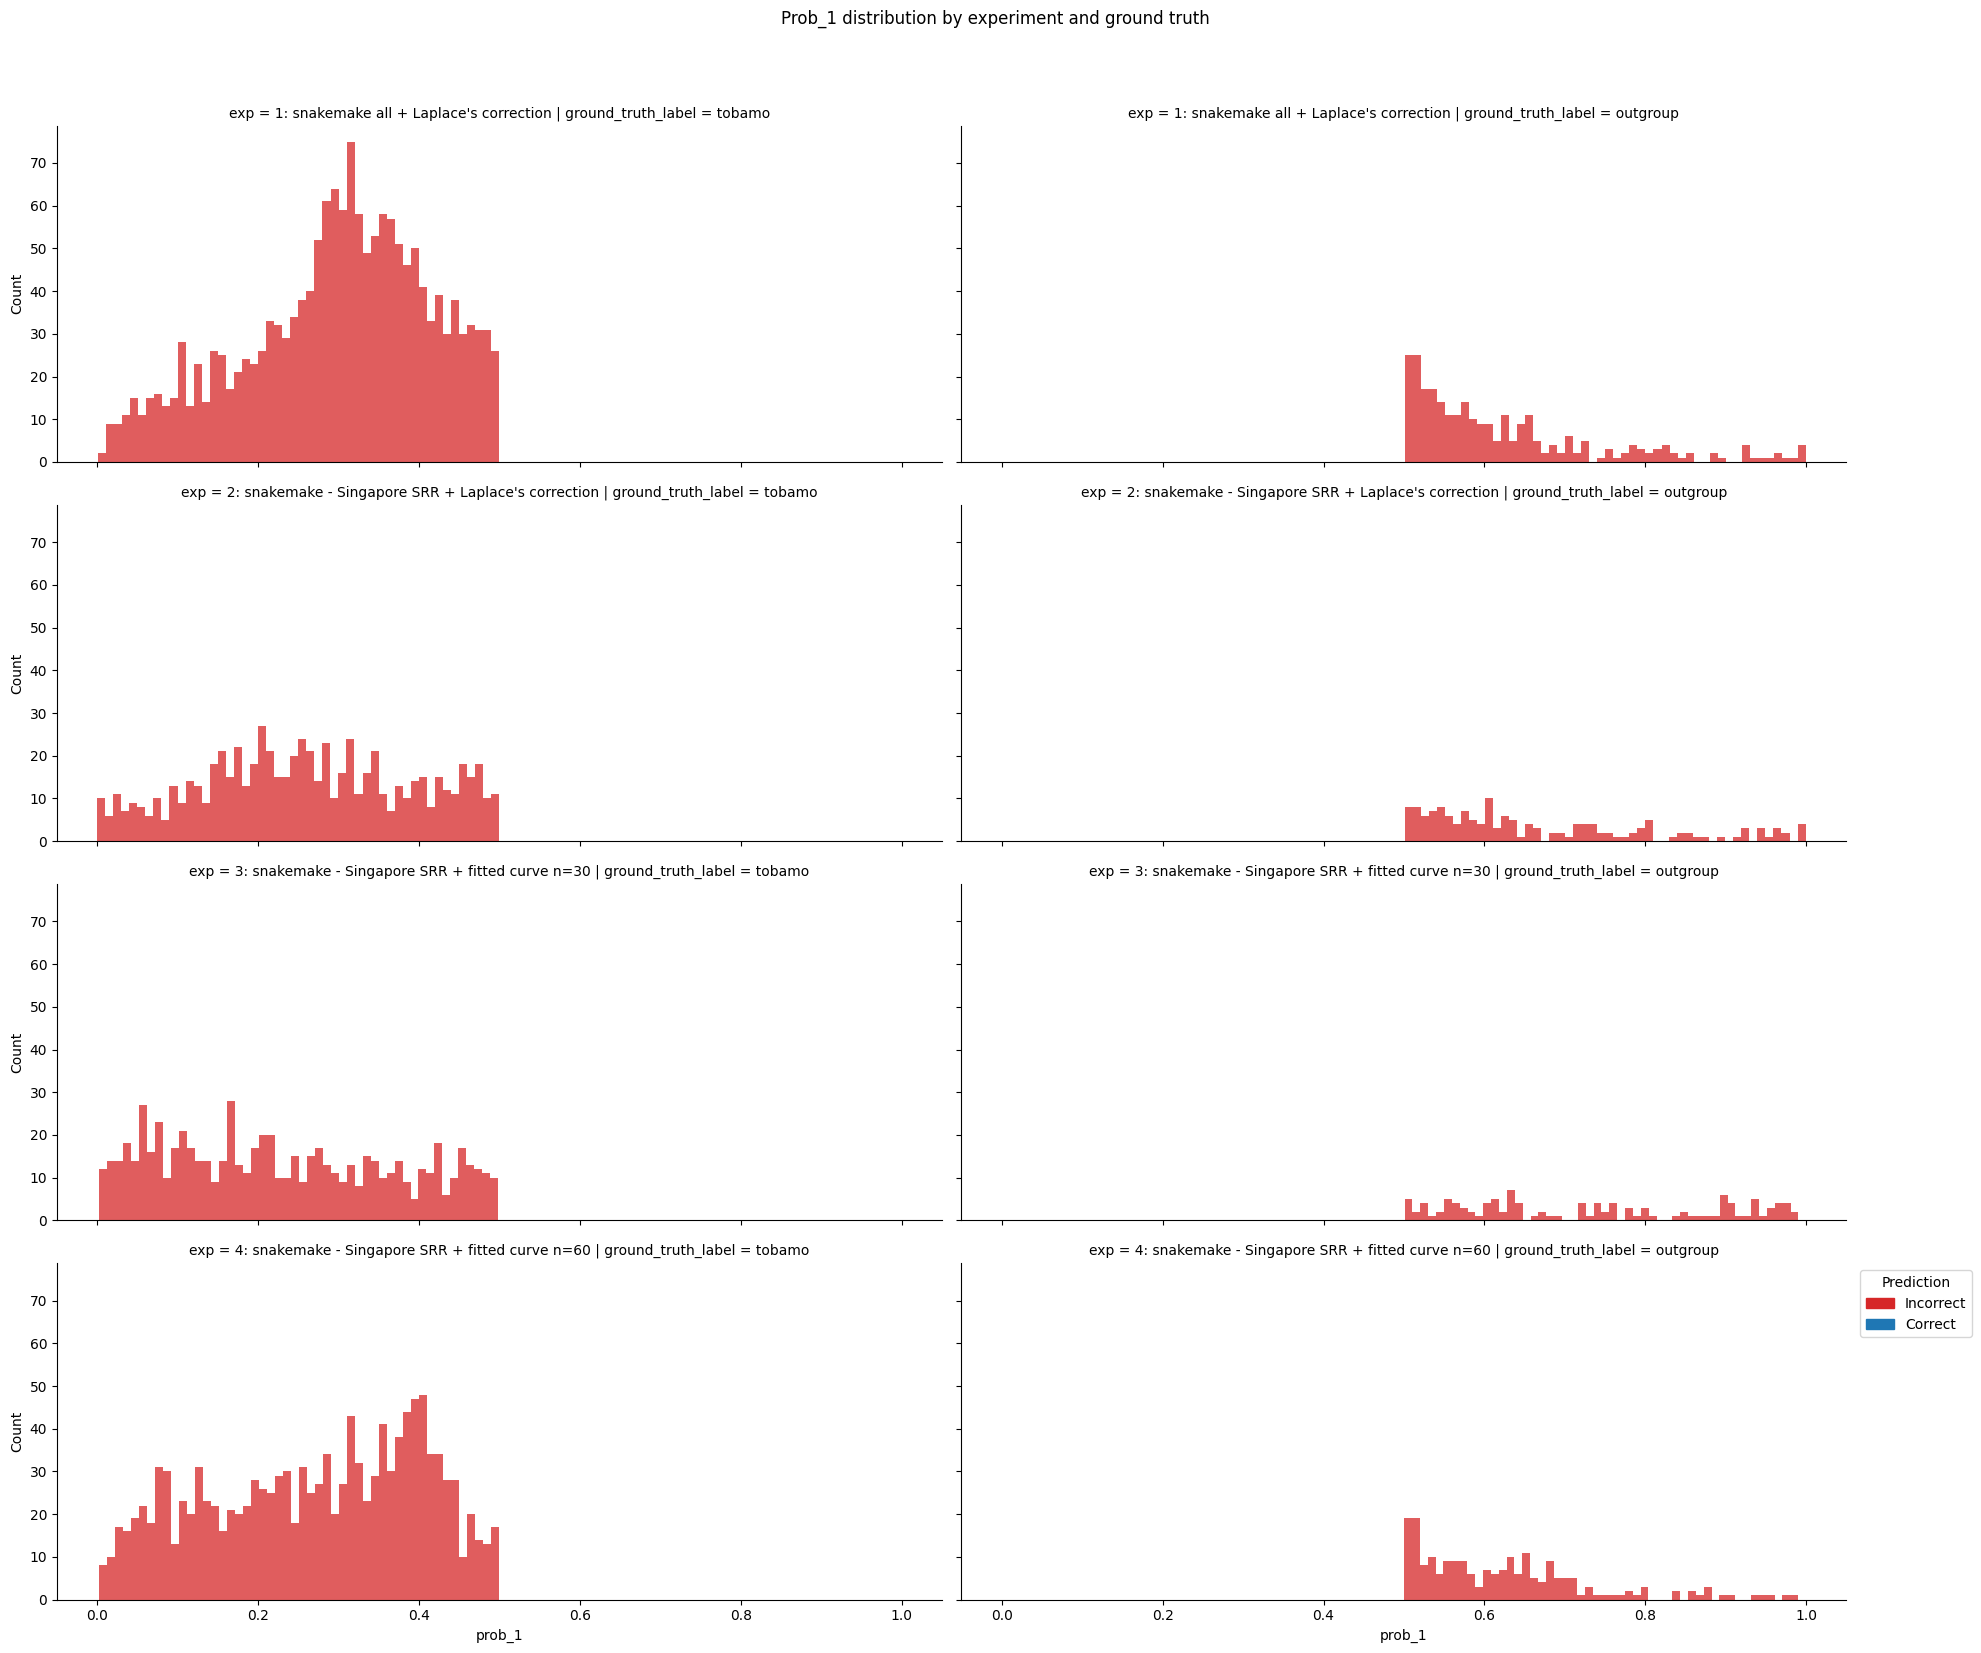

In [22]:
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

col_labels = {0.0: 'outgroup', 1.0: 'tobamo'}
df['ground_truth_label'] = df['ground_truth'].map(col_labels)

g = sns.FacetGrid(
    df,
    row="exp",
    col="ground_truth_label",
    height=4,          # Increase height for better readability
    aspect=2.5,        # Make each subplot wider
    sharey=True,
    margin_titles=False
)
g.map_dataframe(
    sns.histplot,
    x="prob_1",
    hue="correct",
    bins=50,
    multiple="stack",
    palette={0: "tab:red", 1: "tab:blue"},
    edgecolor=None
)
g.set_axis_labels("prob_1", "Count")
# g.set_titles(row_template="exp = {row_name}", col_template="ground_truth = {col_name}")

# Reduce space between subplots
g.fig.subplots_adjust(wspace=0.05, hspace=0.15)

# Custom legend with correct colors and labels
handles = [
    mpatches.Patch(color='tab:red', label='Incorrect'),
    mpatches.Patch(color='tab:blue', label='Correct')
]
plt.legend(handles=handles, title="Prediction", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.suptitle("Prob_1 distribution by experiment and ground truth", y=1.03)
plt.tight_layout()
plt.show()